# 1. Visualização do dataset

In [ ]:
x={5}


In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py

import src

Using TensorFlow backend.


In [2]:
import make_dataset_final

make_dataset_final.main()

add code root path (with `mylib`, 'acsconv').
Creating dataset...

(150, 200)
[(111, 68), (113, 39), (15, 7), (6, 129), (22, 17), (57, 41), (112, 10), (45, 131), (22, 63), (31, 6)]
Seed: 17
Input shape: (150, 200, 119) (x, y, z)
#Wells sampled: 10
Sampled well locations:
[(111, 68), (113, 39), (15, 7), (6, 129), (22, 17), (57, 41), (112, 10), (45, 131), (22, 63), (31, 6)]

X_train shape: (880, 32, 32, 3)
Y_train shape: (880, 1)
X_test shape: (1769768, 32, 32, 3)
Y_test shape: (1769768, 1)

Saving dataset as "C:\Users\admin\Desktop\cnn-facies-classifier-master\data\interim\stanford6_32.h5"
...
Done!


## Informações do dataset

- Número de exemplos de treinamento e teste
- Shape dos exemplos do dataset
- Distribuições de frequência do conjunto de treinamento e teste

In [6]:
x_train_original.shape

(880, 32, 32, 3)

In [ ]:
a=np.reshape(y_train_original, (880,))
a.shape

Training examples: 880
Test examples: 1769768
Example shape: (32, 32, 3)


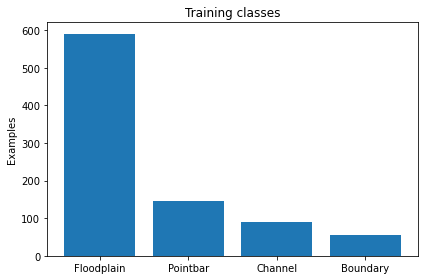

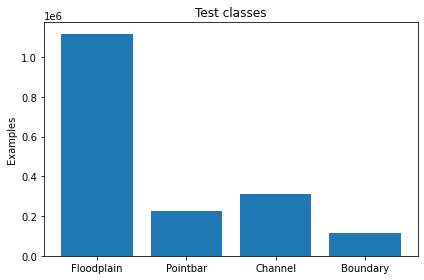

In [4]:
filename = r'C:\Users\admin\Desktop\cnn-facies-classifier-master\data\interim\stanford6_32.h5'
with h5py.File(filename, 'r') as dataset:
    x_train_original = np.array(dataset['train/X'])
    y_train_original = np.array(dataset['train/Y'])
    x_test_original = np.array(dataset['test/X'])
    y_test_original = np.array(dataset['test/Y'])

classnames = {
    0: 'Floodplain',
    1: 'Pointbar',
    2: 'Channel',
    3: 'Boundary',
}    
    
m = x_train_original.shape[0]
num_classes = 4

train_freq = src.class_frequency(y_train_original, num_classes)
test_freq = src.class_frequency(y_test_original, num_classes)

print(f"Training examples: {y_train_original.shape[0]}")
print(f"Test examples: {y_test_original.shape[0]}")
print(f"Example shape: {x_train_original.shape[1:]}")

src.plot_classes_freq(train_freq, classnames.values(), title='Training classes')
src.plot_classes_freq(test_freq, classnames.values(), title='Test classes')

Visualização de 10 imagens de treinamento aleatórias

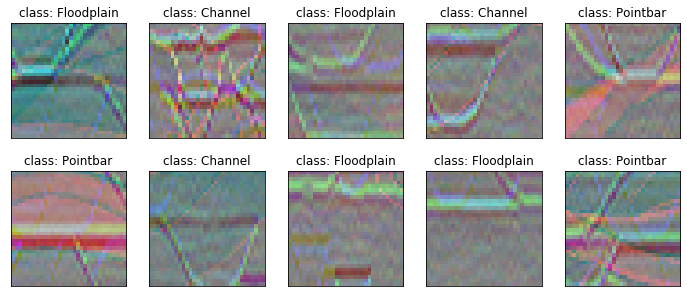

In [4]:
nrows, ncols = 2, 5
idx = np.random.choice(m, nrows * ncols)
fig = plt.figure(figsize=(12, 5))
for i in range(1, nrows * ncols +1):
    fig.add_subplot(nrows, ncols, i)
    plt.imshow(x_train_original[idx[i-1]])
    plt.title(f'class: {classnames[y_train_original[idx[i-1]][0]]}')
    plt.xticks([])
    plt.yticks([]) 

[**2. Data preparation**](02-data-preparation.ipynb)

In [5]:

import os
import matplotlib.pyplot as plt
import numpy as np
import h5py
import src

In [6]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import h5py
import keras
from imblearn.over_sampling import RandomOverSampler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


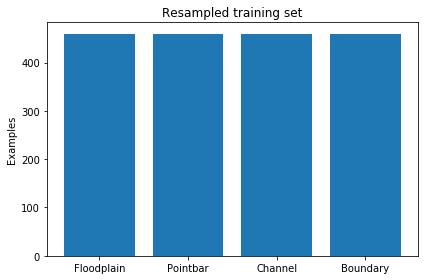

In [7]:
filename = r'C:\Users\admin\Desktop\cnn-facies-classifier-master\data\interim\stanford6_32.h5'
with h5py.File(filename, 'r') as dataset:
    x_train_original = np.array(dataset['train/X'])
    y_train_original = np.array(dataset['train/Y'])
    x_test_original = np.array(dataset['test/X'])
    y_test_original = np.array(dataset['test/Y'])


classnames = {
    0: 'Floodplain',
    1: 'Pointbar',
    2: 'Channel',
    3: 'Boundary',
}        

m = x_train_original.shape[0]
num_classes = 4

resampler = RandomOverSampler()

x_train_resampled, y_train_resampled = resampler.fit_resample(
    np.reshape(x_train_original, (m, np.product(x_train_original.shape[1:]))), 
    y_train_original
)
x_train_resampled = np.reshape(
    x_train_resampled, 
    (x_train_resampled.shape[0], *x_train_original.shape[1:])
)

#tentar puxar so cubo original os labels das coordenadas após o balanceamento

src.plot_classes_freq(
    src.class_frequency(y_train_resampled, num_classes),
    classnames.values(),
    title='Resampled training set'
)

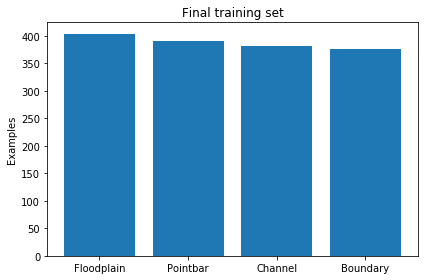

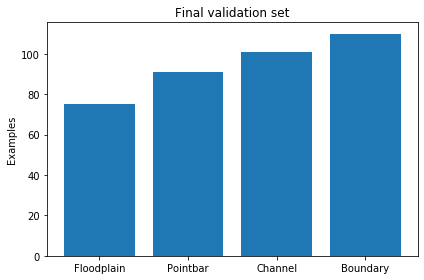

In [17]:
np.random.seed(42)

m = x_train_resampled.shape[0]
idx = np.random.choice(m, int(m * 0.2))
mask = np.ones(m, dtype=bool)
mask[idx] = False

x_train_split, x_val_split = x_train_resampled[mask], x_train_resampled[idx]
y_train_split, y_val_split = y_train_resampled[mask], y_train_resampled[idx]



x_train = x_train_split.astype('float16') / 255
y_train = keras.utils.to_categorical(y_train_split, num_classes)

x_val = x_val_split.astype('float16') / 255
y_val= keras.utils.to_categorical(y_val_split, num_classes)

x_test = x_test_original.astype('float16') / 255
y_test = keras.utils.to_categorical(y_test_original, num_classes)

out_filename = r'C:\Users\admin\Desktop\cnn-facies-classifier-master\data\processed\stanford6_32.h5'

with h5py.File(out_filename, 'w') as file:
    file.create_dataset('test/X', data=x_test)
    file.create_dataset('test/Y', data=y_test)
    
    file.create_dataset('val/X', data=x_val)
    file.create_dataset('val/Y', data=y_val)
    
    file.create_dataset('train/X', data=x_train)
    file.create_dataset('train/Y', data=y_train)




src.plot_classes_freq(
    src.class_frequency(y_train_split, num_classes),
    classnames.values(),
    title='Final training set'
)

src.plot_classes_freq(
    src.class_frequency(y_val_split, num_classes),
    classnames.values(),
    title='Final validation set'
)

In [ ]:
[x_train.shape,x_val.shape]

In [8]:
#Sem balanceamento

np.random.seed(22)

m = x_train_original.shape[0]
idx = np.random.choice(m, int(m * 0.2))
mask = np.ones(m, dtype=bool)
mask[idx] = False

x_train_split, x_val_split = x_train_original, x_train_original
y_train_split, y_val_split = y_train_original, y_train_original

#x_train_split, x_val_split = x_train_resampled[mask], x_train_resampled[idx]
#y_train_split, y_val_split = y_train_resampled[mask], y_train_resampled[idx]


x_train = x_train_split.astype('float16') / 255
y_train = keras.utils.to_categorical(y_train_split, num_classes)

x_val = x_val_split.astype('float16') / 255
y_val= keras.utils.to_categorical(y_val_split, num_classes)

x_test = x_test_original.astype('float16') / 255
y_test = keras.utils.to_categorical(y_test_original, num_classes)

out_filename = r'C:\Users\admin\Desktop\cnn-facies-classifier-master\data\processed\stanford6_32.h5'

with h5py.File(out_filename, 'w') as file:
    file.create_dataset('test/X', data=x_test)
    file.create_dataset('test/Y', data=y_test)
    
    file.create_dataset('val/X', data=x_val)
    file.create_dataset('val/Y', data=y_val)
    
    file.create_dataset('train/X', data=x_train)
    file.create_dataset('train/Y', data=y_train)

In [ ]:
# 3. Treinamento da rede

In [4]:
%load_ext autoreload
%autoreload 2

%matplotlib inline


import matplotlib.pyplot as plt
import numpy as np
import h5py
import keras
import k3d
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

from livelossplot.keras import PlotLossesCallback
from sklearn.metrics import confusion_matrix, f1_score
from ipywidgets import interact, widgets

import src

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
x_test.shape

(1769768, 32, 32, 3)

In [6]:
with h5py.File('data\\processed\stanford6_32.h5', 'r') as dataset:
    x_train = np.array(dataset['train/X'])
    y_train = np.array(dataset['train/Y'])
    x_val = np.array(dataset['val/X'])
    y_val = np.array(dataset['val/Y'])

classnames = {
    0: 'Floodplain',
    1: 'Pointbar',
    2: 'Channel',
    3: 'Boundary',
}    
    
m = x_train.shape[0]
num_classes = 4

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

input_shape = x_train.shape[1:]

model = Sequential()

model.add(Conv2D(32, (7, 7), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (5, 5), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(200))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0, amsgrad=False)

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['acc', f1_m,precision_m, recall_m]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4736      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        51264     
_________________________________________________________________
activation_2 (Activation)    (None, 12, 12, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)         

C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\livelossplot\core.py:57: UserWarning: Attempting to set identical left == right == 1 results in singular transformations; automatically expanding.
  plt.xlim(1 + skip, max_epoch)
C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\livelossplot\core.py:57: UserWarning: Attempting to set identical left == right == 1 results in singular transformations; automatically expanding.
  plt.xlim(1 + skip, max_epoch)
C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\livelossplot\core.py:57: UserWarning: Attempting to set identical left == right == 1 results in singular transformations; automatically expanding.
  plt.xlim(1 + skip, max_epoch)
C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\livelossplot\core.py:57: UserWarning: Attempting to set identical left == right == 1 results in singular transformations; automatically expanding.
  plt.xlim(1 + skip, max_epoch)
C:\Users\admin\AppData\Roaming\Python\Py

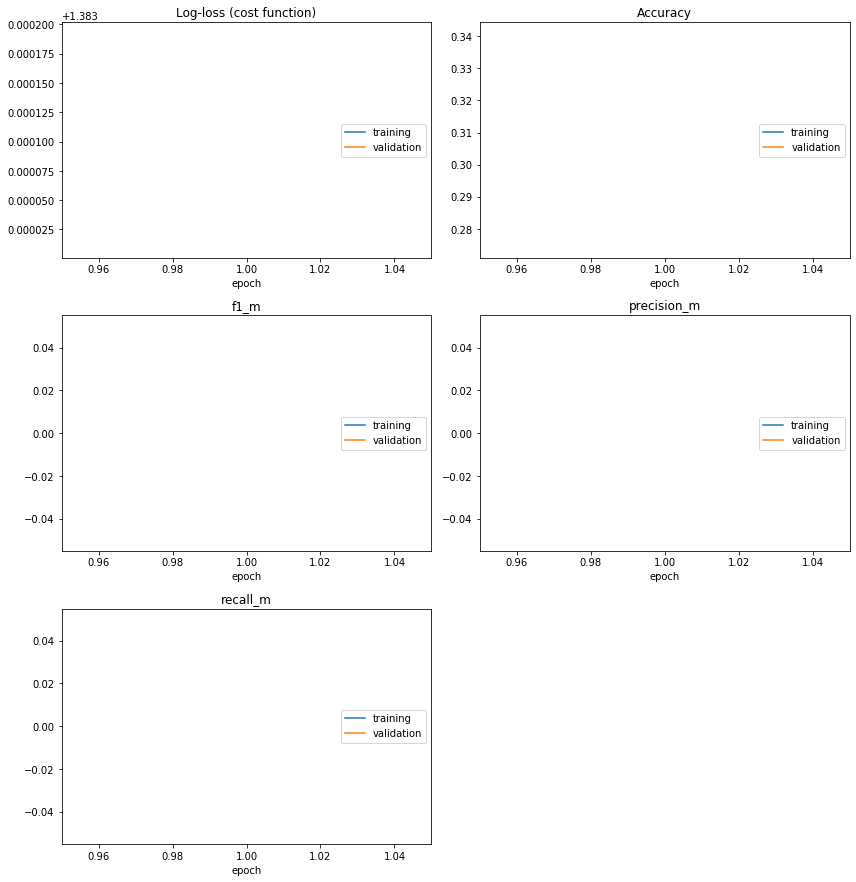

Log-loss (cost function):
training   (min:    1.383, max:    1.383, cur:    1.383)
validation (min:    1.383, max:    1.383, cur:    1.383)

Accuracy:
training   (min:    0.274, max:    0.274, cur:    0.274)
validation (min:    0.341, max:    0.341, cur:    0.341)

f1_m:
training   (min:    0.000, max:    0.000, cur:    0.000)
validation (min:    0.000, max:    0.000, cur:    0.000)

precision_m:
training   (min:    0.000, max:    0.000, cur:    0.000)
validation (min:    0.000, max:    0.000, cur:    0.000)

recall_m:
training   (min:    0.000, max:    0.000, cur:    0.000)
validation (min:    0.000, max:    0.000, cur:    0.000)


In [8]:
import timeit
batch_size = 32
epochs = 1
start_time = timeit.default_timer()
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=epochs,
    shuffle=True,
    callbacks=[PlotLossesCallback()],
)
elapsed = timeit.default_timer() - start_time


In [22]:
elapsed

1799.2995005999983

In [9]:
model.save(r'C:\Users\admin\Desktop\cnn-facies-classifier-master/models/trained_model_32.h5')
print('Model saved!')

Model saved!


In [10]:
#TESTE DO MODELO

%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
import keras
import k3d
from sklearn.metrics import confusion_matrix,jaccard_score, f1_score, precision_score, recall_score
from ipywidgets import interact, widgets

import src
with h5py.File(r'C:\Users\admin\Desktop\cnn-facies-classifier-master\data\processed\stanford6_32.h5', 'r') as dataset:
    x_test = np.array(dataset['test/X'])
    y_test = np.array(dataset['test/Y'])

classnames = {
    0: 'Floodplain',
    1: 'Pointbar',
    2: 'Channel',
    3: 'Boundary',
}

model = keras.models.load_model(r'C:\Users\admin\Desktop\cnn-facies-classifier-master\models/trained_model_32.h5', custom_objects={"f1_m":f1_m,"precision_m":precision_m,"recall_m": recall_m})
model.summary()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4736      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        51264     
_________________________________________________________________
activation_2 (Activation)    (None, 12, 12, 64)        0         
________________________________

Evaluating model...

Precision: 	0.8185223133559649
Recall: 	0.819030516994318
F1-Score: 	0.8176175212454092
IOU: 	0.7326609440585607
elapsed:  	 269.9603742999998


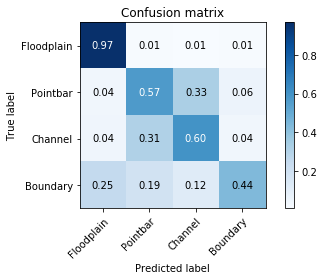

In [14]:
import timeit
import numpy as np
print('Evaluating model...\n')
start_time = timeit.default_timer()

y_pred = np.argmax(model.predict(x_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
jaccard=jaccard_score(y_true, y_pred, average='weighted')

elapsed = timeit.default_timer() - start_time



matrix = confusion_matrix(y_true, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

print(f'Precision: \t{precision}')
print(f'Recall: \t{recall}')
print(f'F1-Score: \t{f1}')
print(f'IOU: \t{jaccard}')
elapsed = timeit.default_timer() - start_time
print(f'elapsed:  \t {elapsed}')

src.plot_confusion_matrix(matrix, classnames.values(), title="Confusion matrix")

In [10]:
print(f'Precision: \t{precision}')
print(f'Recall: \t{recall}')
print(f'F1-Score: \t{f1}')
print(f'IOU: \t{jaccard}')
elapsed = timeit.default_timer() - start_time
print(f'elapsed:  \t {elapsed}')

Precision: 	0.7945507190594503
Recall: 	0.8008874609553343
F1-Score: 	0.7966957473003277
IOU: 	0.7096656757728717
elapsed:  	 265.21373070000004


In [ ]:
image_size = 32
output_shape = [150 + 1 - image_size, 200 + 1 - image_size, 119 + 1 - image_size]

def plot_section(z=0):
    plt.subplot(121)
    plt.imshow(y_true.reshape(output_shape)[:,:,z].T)
    plt.subplot(122)
    plt.imshow(y_pred.reshape(output_shape)[:,:,z].T)

interact(plot_section, z=widgets.IntSlider(min=0,max=119 - image_size,step=1,value=0))




In [ ]:
color_map = (0x3A528B, 0x20908C, 0xFDE724)

plot = k3d.plot(camera_auto_fit=False)
obj = k3d.voxels(y_true.reshape(output_shape).T, color_map, compression_level=1)
plot += obj
plot.camera=[150, 230, -40, 60, 85, 80, 0.0, 0.0, -1.0]
plot.display()

In [ ]:
x_train.shape

In [ ]:
import numpy as np
data= np.load(r'C:/Users/admin/Desktop/cnn-facies-classifier-master/data/interim/trainACS.npz')
shape = data['shape']
segs = data['segs']
#segs=np.rollaxis(segs, -1, 1)
#segs = segs
segs[1]

train_set = BaseDatasetShape(env.ACS_train, x_train_ACS.shape[0])

train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True,
                            pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)


len(train_loader)

In [2]:
# encoding: utf-8
#Train2D

import _init_paths
import shutil
import fire
import time
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torch.nn.functional as F
from sklearn import metrics as met
from tqdm import tqdm
from collections import OrderedDict
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter
from sklearn.metrics import roc_auc_score
from unet import UNet
from poc_dataset_ACS import BaseDatasetShape
from mylib.loss import soft_dice_loss
from mylib.utils import MultiAverageMeter, save_model, log_results, to_var, set_seed, \
        to_device, initialize, categorical_to_one_hot, copy_file_backup, redirect_stdout
from mylib.metrics import cal_batch_iou, cal_batch_dice, AUROC_per_case
from mylib.loss import soft_dice_loss
from poc_config import POCShapeConfig as cfg
from poc_config import POCShapeEnv as env
from livelossplot import PlotLosses
import matplotlib

matplotlib.use('TKAgg',warn=False, force=True)

import timeit
start_time = timeit.default_timer()


grafico={}
liveloss = PlotLosses()
def main(save_path=cfg.save, 
         batch_size=cfg.batch_size, 
         n_epochs=cfg.n_epochs, 
         drop_rate=cfg.drop_rate,
         seed=cfg.seed
         ):
    start_time = timeit.default_timer()
    if seed is not None:
        torch.manual_seed(cfg.seed)
    cudnn.benchmark = True

    #if os.path.exists(save_path):
        #shutil.rmtree(save_path,ignore_errors=True)
    os.makedirs(save_path,exist_ok = True)
    #copy_file_backup(save_path)
    redirect_stdout(save_path)

    # Datasets
    train_data = env.data_train
    test_data = env.data_test
    
    



    train_set = BaseDatasetShape(train_data, cfg.train_samples)
    valid_set = None
    test_set = BaseDatasetShape(test_data, cfg.test_samples)


    # Models
    model = UNet(4) #3 é o numero de classes
    #model= UNet(n_channels=3, n_classes=1, bilinear=True)
    initialize(model.modules())

    # Train the model
    train(model=model, train_set=train_set, valid_set=valid_set, test_set=test_set, save=save_path, n_epochs=n_epochs)
    elapsed = timeit.default_timer() - start_time
    print(elapsed)
    print('Done!')


def train(model, train_set, test_set, save, valid_set, n_epochs):
    
    

    # Data loaders
    train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
    test_loader = DataLoader(test_set, batch_size=cfg.batch_size, shuffle=False,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
    if valid_set is None:
        valid_loader = None
    else:
        valid_loader = DataLoader(valid_set, batch_size=cfg.batch_size, shuffle=False,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
    # Model on cuda
    model = to_device(model)

    # Wrap model for multi-GPUs, if necessary
    model_wrapper = model
    if torch.cuda.is_available() and torch.cuda.device_count() > 1:
        model_wrapper = torch.nn.DataParallel(model).cuda()

    # Optimizer
    optimizer = torch.optim.SGD(model_wrapper.parameters(), lr=cfg.lr, weight_decay=cfg.wd, momentum=cfg.momentum)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=cfg.milestones,
                                                     gamma=cfg.gamma)

    # Start log
    logs = ['loss', 'iou', 'dice'] + ['iou{}'.format(i) for i in range(2)]+['dice{}'.format(i) for i in range(2)]
    train_logs = ['train_'+log for log in logs]
    test_logs = ['test_'+log for log in logs]
    log_dict = OrderedDict.fromkeys(train_logs+test_logs, 0)
    with open(os.path.join(save, 'logs.csv'), 'w') as f:
        f.write('epoch,')
        for key in log_dict.keys():
            f.write(key+',')
        f.write('\n')
    writer = SummaryWriter(log_dir=os.path.join(save, 'Tensorboard_Results'))

    # Train model
    best_dice = 0

    for epoch in range(n_epochs):
        os.makedirs(os.path.join(cfg.save, 'epoch_{}'.format(epoch)),exist_ok = True)
        grafico={}
        train_meters = train_epoch(
            model=model_wrapper,
            loader=train_loader,
            optimizer=optimizer,
            epoch=epoch,
            n_epochs=n_epochs,
            writer=writer
        )

        
        
        test_meters = test_epoch(
            model=model_wrapper,
            loader=test_loader,
            epoch=epoch,
            is_test=True,
            writer = writer
        )
        scheduler.step()

        # Log results
        for i, key in enumerate(train_logs):
            log_dict[key] = train_meters[i]
            
        for i, key in enumerate(test_logs):
            log_dict[key] = test_meters[i]

        log_results(save, epoch, log_dict, writer=writer)
        
        grafico['log loss'] = log_dict['train_loss']
        grafico['dice'] = log_dict['train_dice']  

        
        
        if cfg.save_all:
            torch.save(model.state_dict(), os.path.join(save, 'epoch_{}'.format(epoch), 'model.dat'))
        if log_dict['test_dice'] > best_dice:
            torch.save(model.state_dict(), os.path.join(save, 'model.dat'))
            best_dice = log_dict['test_dice']
            print('New best dice: %.4f' % log_dict['test_dice'])
            
        else:
            print('Current best dice: %.4f' % best_dice)
    
    #liveloss.update(grafico)
    #liveloss.send()
    writer.close()


    with open(os.path.join(save, 'logs.csv'), 'a') as f:
        f.write(',,,,best dice,%0.5f\n' % (best_dice))
    # Final test of the best model on test set
    print('best dice: ', best_dice)

iteration = 0


def train_epoch(model, loader, optimizer, epoch, n_epochs, print_freq=1, writer=None):
    meters = MultiAverageMeter()
    # Model on train mode
    model.train()
    global iteration
           
    intersection = 0
    union = 0
    
    
    
    
    end = time.time()
    for batch_idx, (x, y) in enumerate(loader): #tira uma amostra indexada no formato [idx, (x_train,y_train)]
        # Create vaiables
        
        x = to_var(x) #armazena em formato pra GPU (cuda)
        y = to_var(y)
        
        # compute output
        pred_logit = model(x)
        print(pred_logit.shape)
        loss = soft_dice_loss(pred_logit, y, smooth=1e-2)




        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # measure accuracy and record loss
        y = y.long()
        batch_size = y.size(0)
        iou = cal_batch_iou(pred_logit, y)
        dice = cal_batch_dice(pred_logit, y)

        logs = [loss.item(), iou[1:].mean(), dice[1:].mean()]+ \
                            [iou[i].item() for i in range(len(iou))]+ \
                            [dice[i].item() for i in range(len(dice))]+ \
                            [time.time() - end]
        
        
        
        meters.update(logs, batch_size)   
        writer.add_scalar('train_loss_logs', loss.item(), iteration)
        with open(os.path.join(cfg.save, 'loss_logs.csv'), 'a') as f:
            f.write('%09d,%0.6f,\n'%((iteration + 1),loss.item(),))
        iteration += 1
        



        # measure elapsed time
        end = time.time()
        # print stats
        print_freq = 2 // meters.val[-1] + 1
        if batch_idx % print_freq == 0:
            res = '\t'.join([
                'Epoch: [%d/%d]' % (epoch + 1, n_epochs),
                'Iter: [%d/%d]' % (batch_idx + 1, len(loader)),
                'Time %.3f (%.3f)' % (meters.val[-1], meters.avg[-1]),
                'Loss %.4f (%.4f)' % (meters.val[0], meters.avg[0]),
                'IOU %.4f (%.4f)' % (meters.val[1], meters.avg[1]),
                'DICE %.4f (%.4f)' % (meters.val[2], meters.avg[2]),
            ])
  

    return meters.avg[:-1]


def test_epoch(model, loader, epoch, print_freq=1, is_test=True, writer=None):
    meters = MultiAverageMeter()
    # Model on eval mode
    
    global iteration
        
    intersection = 0
    union = 0
    model.eval()
    end = time.time()
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loader):
            # Create vaiables
            x = to_var(x)
            y = to_var(y)
            # compute output
            pred_logit = model(x)
            loss = soft_dice_loss(pred_logit, y, smooth=1e-2)

            #auroc= AUROC_per_case(pred_logit, y)
            
            
            # measure accuracy and record loss
            batch_size = y.size(0)
            iou = cal_batch_iou(pred_logit, y)
            dice = cal_batch_dice(pred_logit, y)

            logs = [loss.item(), iou[1:].mean(), dice[1:].mean()]+ \
                                [iou[i].item() for i in range(len(iou))]+ \
                                [dice[i].item() for i in range(len(dice))]+ \
                                [time.time() - end]
            meters.update(logs, batch_size)

            # measure elapsed time
            end = time.time()

            # print stats
            print_freq = 2 // meters.val[-1] + 1
            if batch_idx % print_freq == 0:
                res = '\t'.join([
                    'Test' if is_test else 'Valid',
                    'Iter: [%d/%d]' % (batch_idx + 1, len(loader)),
                    'Time %.3f (%.3f)' % (meters.val[-1], meters.avg[-1]),
                    'Loss %.4f (%.4f)' % (meters.val[0], meters.avg[0]),
                    'IOU %.4f (%.4f)' % (meters.val[1], meters.avg[1]),
                    'DICE %.4f (%.4f)' % (meters.val[2], meters.avg[2]),
                ])
                print(res)
    return meters.avg[:-1]

if __name__ == '__main__':
    fire.Fire(main)


add code root path (with `mylib`, 'acsconv').


TypeError: __init__() missing 1 required positional argument: 'canal'

In [ ]:
import pandas as pd

x= pd.read_csv(r'C:\Users\admin\Desktop\cnn-facies-classifier-master\tmp\shape_880samples\logs.csv')

x[-5:]

In [ ]:

Test	Iter: [1/14]	Time 0.081 (0.081)	Loss 0.5070 (0.5070)	IOU 0.3060 (0.3060)	DICE 0.4427 (0.4427)
Current best dice: 0.3912
Test	Iter: [1/14]	Time 0.080 (0.080)	Loss 0.5068 (0.5068)	IOU 0.3076 (0.3076)	DICE 0.4444 (0.4444)
New best dice: 0.3915
Test	Iter: [1/14]	Time 0.087 (0.087)	Loss 0.5064 (0.5064)	IOU 0.3073 (0.3073)	DICE 0.4439 (0.4439)
Current best dice: 0.3915
Test	Iter: [1/14]	Time 0.093 (0.093)	Loss 0.5063 (0.5063)	IOU 0.3077 (0.3077)	DICE 0.4443 (0.4443)
New best dice: 0.3916
Test	Iter: [1/14]	Time 0.072 (0.072)	Loss 0.5058 (0.5058)	IOU 0.3080 (0.3080)	DICE 0.4446 (0.4446)
New best dice: 0.3918


In [ ]:
import timeit
start_time = timeit.default_timer()
    elapsed = timeit.default_timer() - start_time
    print(elapsed)

In [ ]:
yone= keras.utils.to_categorical(data['segs'], num_classes)
yone=yone[0,:,:,:]
yone=np.moveaxis(yone,-1,0)
yone.shape

In [ ]:
x.shape

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

restartkernel()

In [ ]:
# encoding: utf-8
#POC 2,5D unet pre trained



import _init_paths

import fire
import time
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torch.nn.functional as F
import sklearn
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from collections import OrderedDict
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

from poc_dataset_ACS import BaseDatasetVoxel
from mylib.loss import soft_cross_entropy_loss
from mylib.utils import MultiAverageMeter, save_model, log_results, to_var, set_seed, \
        to_device, initialize, categorical_to_one_hot, copy_file_backup, redirect_stdout
from poc_config_2dpre import POCVoxelConfig as cfg
from poc_config_2dpre import POCVoxelEnv as env

from unet import UNet
from acsconv.models import ACSUNet
from acsconv.converters import ACSConverter, Conv3dConverter, Conv2_5dConverter

from mylib.metrics import cal_batch_iou, cal_batch_dice, AUROC_per_case
from mylib.loss import soft_dice_loss

import timeit
start_time = timeit.default_timer()

    
def main(save_path=cfg.save, 
         n_epochs=cfg.n_epochs, 
         seed=cfg.seed
         ):
    if seed is not None:
        set_seed(cfg.seed)
    cudnn.benchmark = True



    # # Models
    os.makedirs(save_path,exist_ok = True)
    #copy_file_backup(save_path)
    redirect_stdout(save_path)

    # Datasets
    train_data = env.data_train
    test_data = env.data_train
    shape_cp = env.shape_checkpoint
    #val_data=env.data_test



    train_set = BaseDatasetVoxel(train_data, cfg.train_samples)
    valid_set = None
    test_set = BaseDatasetVoxel(test_data, cfg.train_samples)

    model = UNet(4)
    if cfg.conv == 'Conv3D':
        model = Conv3dConverter(model)
        initialize(model.modules())
    elif cfg.conv == 'Conv2_5D':
        print('REDE 2,5D')
        if cfg.pretrained:
            shape_cp = torch.load(shape_cp)
            shape_cp.popitem()
            shape_cp.popitem()
            incompatible_keys = model.load_state_dict(shape_cp, strict=False)
            print('load shape pretrained weights\n', incompatible_keys)
        model = Conv2_5dConverter(model)
    elif cfg.conv == 'ACSConv':
        # You can use either the naive ``ACSUNet`` or the ``ACSConverter(model)``
        #model = ACSConverter(model)
        model = ACSUNet(4)
        if cfg.pretrained:
            shape_cp = torch.load(shape_cp)
            shape_cp.popitem()
            shape_cp.popitem()
            incompatible_keys = model.load_state_dict(shape_cp, strict=False)
            print('load shape pretrained weights\n', incompatible_keys)
    else:
        raise ValueError('not valid conv')
    
    print(model)
    torch.save(model.state_dict(), os.path.join(save_path, 'model.dat'))
    # Train the model
    train(model=model, train_set=train_set, valid_set=valid_set, test_set=test_set, save=save_path, n_epochs=n_epochs)
    elapsed = timeit.default_timer() - start_time
    print(elapsed)
    print('Done!')



def train(model, train_set, test_set, save, valid_set, n_epochs):


    # Data loaders
    train_loader = DataLoader(train_set, batch_size=cfg.train_batch_size, shuffle=True,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
    test_loader = DataLoader(test_set, batch_size=cfg.test_batch_size, shuffle=False,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
    if valid_set is None:
        valid_loader = None
    else:
        valid_loader = DataLoader(valid_set, batch_size=cfg.batch_size, shuffle=False,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
    # Model on cuda
    model = to_device(model)

    # Wrap model for multi-GPUs, if necessary
    model_wrapper = model
    if torch.cuda.is_available() and torch.cuda.device_count() > 1:
        model_wrapper = torch.nn.DataParallel(model).cuda()

    # Optimizer
    optimizer = torch.optim.Adam(model_wrapper.parameters(), lr=cfg.lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=cfg.milestones,
                                                     gamma=cfg.gamma)

    # Start log
    logs = ['loss', 'iou', 'dice'] + ['iou{}'.format(i) for i in range(4)]+['dice{}'.format(i) for i in range(4)]
    train_logs = ['train_'+log for log in logs]
    test_logs = ['test_'+log for log in logs]
    log_dict = OrderedDict.fromkeys(train_logs+test_logs, 0)
    with open(os.path.join(save, 'logs.csv'), 'w') as f:
        f.write('epoch,')
        for key in log_dict.keys():
            f.write(key+',')
        f.write('\n')
    writer = SummaryWriter(log_dir=os.path.join(save, 'Tensorboard_Results'))

    # Train model
    best_dice = 0

    for epoch in range(n_epochs):
        os.makedirs(os.path.join(cfg.save, 'epoch_{}'.format(epoch)),exist_ok = True)
        train_meters = train_epoch(
            model=model_wrapper,
            loader=train_loader,
            optimizer=optimizer,
            epoch=epoch,
            n_epochs=n_epochs,
            writer=writer
        )
        # if (epoch+1)%5==0:
        test_meters = test_epoch(
            model=model_wrapper,
            loader=test_loader,
            epoch=epoch,
            is_test=True,
            writer = writer
        )
        scheduler.step()

        # Log results
        for i, key in enumerate(train_logs):
            log_dict[key] = train_meters[i]
        for i, key in enumerate(test_logs):
            log_dict[key] = test_meters[i]

        log_results(save, epoch, log_dict, writer=writer)

        if cfg.save_all:
            torch.save(model.state_dict(), os.path.join(save, 'epoch_{}'.format(epoch), 'model.dat'))

        if log_dict['test_dice'] > best_dice:
            torch.save(model.state_dict(), os.path.join(save, 'model.dat'))
            best_dice = log_dict['test_dice']
            print('New best dice: %.4f' % log_dict['test_dice'])
            #print(2.*intersection/union)
        else:
            print('Current best dice: %.4f' % best_dice)
            #print(2.*intersection/union)
    writer.close()

    with open(os.path.join(save, 'logs.csv'), 'a') as f:
        f.write(',,,,best dice,%0.5f\n' % (best_dice))
    # Final test of the best model on test set
    print('best dice: ', best_dice)

iteration = 0

def train_epoch(model, loader, optimizer, epoch, n_epochs, print_freq=1, writer=None):
    meters = MultiAverageMeter()
    # Model on train mode
    model.train()
    global iteration
    end = time.time()
    for batch_idx, (x, y) in enumerate(loader):
        # Create vaiables
        x = to_var(x)
        y = to_var(y)
        # compute output
        pred_logit = model(x)
        loss = soft_dice_loss(pred_logit, y, smooth=1e-2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y = y.long()
        
        batch_size = y.size(0)
        iou = cal_batch_iou(pred_logit, y)
        dice = cal_batch_dice(pred_logit, y)

        logs = [loss.item(), iou[1:].mean(), dice[1:].mean()]+ \
                            [iou[i].item() for i in range(len(iou))]+ \
                            [dice[i].item() for i in range(len(dice))]+ \
                            [time.time() - end]
        meters.update(logs, batch_size)   
        writer.add_scalar('train_loss_logs', loss.item(), iteration)
        with open(os.path.join(cfg.save, 'loss_logs.csv'), 'a') as f:
            f.write('%09d,%0.6f,\n'%((iteration + 1),loss.item(),))
        iteration += 1


        # measure elapsed time
        end = time.time()
        # print stats
        print_freq = 2 // meters.val[-1] + 1
        if batch_idx % print_freq == 0:
            res = '\t'.join([
                'Epoch: [%d/%d]' % (epoch + 1, n_epochs),
                'Iter: [%d/%d]' % (batch_idx + 1, len(loader)),
                'Time %.3f (%.3f)' % (meters.val[-1], meters.avg[-1]),
                'Loss %.4f (%.4f)' % (meters.val[0], meters.avg[0]),
                'IOU %.4f (%.4f)' % (meters.val[1], meters.avg[1]),
                'DICE %.4f (%.4f)' % (meters.val[2], meters.avg[2]),
            ])
            print(res)

    return meters.avg[:-1] #intersection, union


def test_epoch(model, loader, epoch, print_freq=1, is_test=True, writer=None):
    meters = MultiAverageMeter()
    # Model on eval mode
    model.eval()
    gt_classes = []
    pred_all_probs = []
    end = time.time()
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loader):
            
            x = to_var(x)
            
            
            y = to_var(y)
            
            pred_logit = model(x)
            
            # calculate metrics
            pred_class = pred_logit.max(dim=1)[1]
            pred_probs = pred_logit.softmax(-1)
            pred_all_probs.append(pred_probs.cpu())
            gt_classes.append(y.cpu())
            
            #print(gt_classes.shape) #pred_class[20,48,48,48]
            #print(pred_probs[1]) #y e pred_probs[20,6,48,48,48]
            
            batch_size, n_classes = pred_logit.shape[:2]
            

            loss = soft_dice_loss(pred_logit, y, smooth=1e-2)
            y = y.long()
            batch_size = y.size(0)
            iou = cal_batch_iou(pred_logit, y)
            dice = cal_batch_dice(pred_logit, y)
 
            logs = [loss.item(), iou[1:].mean(), dice[1:].mean()]+ \
                                [iou[i].item() for i in range(len(iou))]+ \
                                [dice[i].item() for i in range(len(dice))]+ \
                                [time.time() - end]
            meters.update(logs, batch_size)

            end = time.time()

            print_freq = 2 // meters.val[-1] + 1
            if batch_idx % print_freq == 0:
                res = '\t'.join([
                    'Test' if is_test else 'Valid',
                    'Iter: [%d/%d]' % (batch_idx + 1, len(loader)),
                    'Time %.3f (%.3f)' % (meters.val[-1], meters.avg[-1]),
                    'Loss %.4f (%.4f)' % (meters.val[0], meters.avg[0]),
                    'IOU %.4f (%.4f)' % (meters.val[1], meters.avg[1]),
                    'DICE %.4f (%.4f)' % (meters.val[2], meters.avg[2]),
                ])
                print(res)

    return meters.avg[:-1]

if __name__ == '__main__':
    fire.Fire(main)



In [ ]:
# encoding: utf-8
#POC ACS conv UNET pre-trained
import _init_paths
import timeit
start_time = timeit.default_timer()
# code you want to evaluate

import fire
import time
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torch.nn.functional as F
import sklearn
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from collections import OrderedDict
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

from poc_dataset_ACS import BaseDatasetVoxel
from mylib.loss import soft_cross_entropy_loss
from mylib.utils import MultiAverageMeter, save_model, log_results, to_var, set_seed, \
        to_device, initialize, categorical_to_one_hot, copy_file_backup, redirect_stdout
from poc_config import POCVoxelConfig as cfg
from poc_config import POCVoxelEnv as env

from unet import UNet
from acsconv.models import ACSUNet
from acsconv.converters import ACSConverter, Conv3dConverter, Conv2_5dConverter

from mylib.metrics import cal_batch_iou, cal_batch_dice
from mylib.loss import soft_dice_loss
import timeit
start_time = timeit.default_timer()
# code you want to evaluate

def main(save_path=cfg.save, 
         n_epochs=cfg.n_epochs, 
         seed=cfg.seed
         ):
    if seed is not None:
        set_seed(cfg.seed)
    cudnn.benchmark = True



    # # Models
    os.makedirs(save_path,exist_ok = True)
    #copy_file_backup(save_path)
    redirect_stdout(save_path)

    # Datasets
    train_data = env.data_train
    test_data = env.data_train
    shape_cp = env.shape_checkpoint
    



    train_set = BaseDatasetVoxel(train_data, cfg.train_samples)
    valid_set = None
    test_set = BaseDatasetVoxel(test_data, cfg.train_samples)

    model = UNet(4)
    if cfg.conv == 'Conv3D':
        model = Conv3dConverter(model)
        initialize(model.modules())
    elif cfg.conv == 'Conv2_5D':
        print('REDE 2,5D')
        if cfg.pretrained:
            shape_cp = torch.load(shape_cp)
            shape_cp.popitem()
            shape_cp.popitem()
            incompatible_keys = model.load_state_dict(shape_cp, strict=False)
            print('load shape pretrained weights\n', incompatible_keys)
        model = Conv2_5dConverter(model)
    elif cfg.conv == 'ACSConv':
        # You can use either the naive ``ACSUNet`` or the ``ACSConverter(model)``
        #model = ACSConverter(model)
        model = ACSUNet(4)
        if cfg.pretrained:
            shape_cp = torch.load(shape_cp)
            shape_cp.popitem()
            shape_cp.popitem()
            incompatible_keys = model.load_state_dict(shape_cp, strict=False)
            print('load shape pretrained weights\n', incompatible_keys)
    else:
        raise ValueError('not valid conv')
    
    print(model)
    torch.save(model.state_dict(), os.path.join(save_path, 'model.dat'))
    # Train the model
    train(model=model, train_set=train_set, valid_set=valid_set, test_set=test_set, save=save_path, n_epochs=n_epochs)
    
    elapsed = timeit.default_timer() - start_time
    print(elapsed)
    print('Done!')



def train(model, train_set, test_set, save, valid_set, n_epochs):


    # Data loaders
    train_loader = DataLoader(train_set, batch_size=cfg.train_batch_size, shuffle=True,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
    test_loader = DataLoader(test_set, batch_size=cfg.test_batch_size, shuffle=False,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
    if valid_set is None:
        valid_loader = None
    else:
        valid_loader = DataLoader(valid_set, batch_size=cfg.batch_size, shuffle=False,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
    # Model on cuda
    model = to_device(model)

    # Wrap model for multi-GPUs, if necessary
    model_wrapper = model
    if torch.cuda.is_available() and torch.cuda.device_count() > 1:
        model_wrapper = torch.nn.DataParallel(model).cuda()

    # Optimizer
    optimizer = torch.optim.Adam(model_wrapper.parameters(), lr=cfg.lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=cfg.milestones,
                                                     gamma=cfg.gamma)

    # Start log
    logs = ['loss', 'iou', 'dice'] + ['iou{}'.format(i) for i in range(4)]+['dice{}'.format(i) for i in range(4)]
    train_logs = ['train_'+log for log in logs]
    test_logs = ['test_'+log for log in logs]
    log_dict = OrderedDict.fromkeys(train_logs+test_logs, 0)
    with open(os.path.join(save, 'logs.csv'), 'w') as f:
        f.write('epoch,')
        for key in log_dict.keys():
            f.write(key+',')
        f.write('\n')
    writer = SummaryWriter(log_dir=os.path.join(save, 'Tensorboard_Results'))

    # Train model
    best_dice = 0

    for epoch in range(n_epochs):
        os.makedirs(os.path.join(cfg.save, 'epoch_{}'.format(epoch)),exist_ok = True)
        train_meters = train_epoch(
            model=model_wrapper,
            loader=train_loader,
            optimizer=optimizer,
            epoch=epoch,
            n_epochs=n_epochs,
            writer=writer
        )
        # if (epoch+1)%5==0:
        test_meters = test_epoch(
            model=model_wrapper,
            loader=test_loader,
            epoch=epoch,
            is_test=True,
            writer = writer
        )
        scheduler.step()

        # Log results
        for i, key in enumerate(train_logs):
            log_dict[key] = train_meters[i]
        for i, key in enumerate(test_logs):
            log_dict[key] = test_meters[i]

        log_results(save, epoch, log_dict, writer=writer)

        if cfg.save_all:
            torch.save(model.state_dict(), os.path.join(save, 'epoch_{}'.format(epoch), 'model.dat'))

        if log_dict['test_dice'] > best_dice:
            torch.save(model.state_dict(), os.path.join(save, 'model.dat'))
            best_dice = log_dict['test_dice']
            print('New best dice: %.4f' % log_dict['test_dice'])
            #print(2.*intersection/union)
        else:
            print('Current best dice: %.4f' % best_dice)
            #print(2.*intersection/union)
    writer.close()

    with open(os.path.join(save, 'logs.csv'), 'a') as f:
        f.write(',,,,best dice,%0.5f\n' % (best_dice))
    # Final test of the best model on test set
    print('best dice: ', best_dice)

iteration = 0

def train_epoch(model, loader, optimizer, epoch, n_epochs, print_freq=1, writer=None):
    meters = MultiAverageMeter()
    # Model on train mode
    model.train()
    global iteration
    end = time.time()
    for batch_idx, (x, y) in enumerate(loader):
        # Create vaiables
        x = to_var(x)
        y = to_var(y)
        # compute output
        pred_logit = model(x)
        loss = soft_dice_loss(pred_logit, y, smooth=1e-2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y = y.long()
        
        batch_size = y.size(0)
        iou = cal_batch_iou(pred_logit, y)
        dice = cal_batch_dice(pred_logit, y)

        logs = [loss.item(), iou[1:].mean(), dice[1:].mean()]+ \
                            [iou[i].item() for i in range(len(iou))]+ \
                            [dice[i].item() for i in range(len(dice))]+ \
                            [time.time() - end]
        meters.update(logs, batch_size)   
        writer.add_scalar('train_loss_logs', loss.item(), iteration)
        with open(os.path.join(cfg.save, 'loss_logs.csv'), 'a') as f:
            f.write('%09d,%0.6f,\n'%((iteration + 1),loss.item(),))
        iteration += 1


        # measure elapsed time
        end = time.time()
        # print stats
        print_freq = 2 // meters.val[-1] + 1
        if batch_idx % print_freq == 0:
            res = '\t'.join([
                'Epoch: [%d/%d]' % (epoch + 1, n_epochs),
                'Iter: [%d/%d]' % (batch_idx + 1, len(loader)),
                'Time %.3f (%.3f)' % (meters.val[-1], meters.avg[-1]),
                'Loss %.4f (%.4f)' % (meters.val[0], meters.avg[0]),
                'IOU %.4f (%.4f)' % (meters.val[1], meters.avg[1]),
                'DICE %.4f (%.4f)' % (meters.val[2], meters.avg[2]),
            ])
            print(res)

    return meters.avg[:-1] #intersection, union


def test_epoch(model, loader, epoch, print_freq=1, is_test=True, writer=None):
    meters = MultiAverageMeter()
    # Model on eval mode
    model.eval()
    gt_classes = []
    pred_all_probs = []
    end = time.time()
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loader):
            
            x = to_var(x)
            
            
            y = to_var(y)
            
            pred_logit = model(x)
            
            # calculate metrics
            pred_class = pred_logit.max(dim=1)[1]
            pred_probs = pred_logit.softmax(-1)
            pred_all_probs.append(pred_probs.cpu())
            gt_classes.append(y.cpu())
            
            #print(gt_classes.shape) #pred_class[20,48,48,48]
            #print(pred_probs[1]) #y e pred_probs[20,6,48,48,48]
            
            batch_size, n_classes = pred_logit.shape[:2]
            

            loss = soft_dice_loss(pred_logit, y, smooth=1e-2)
            y = y.long()
            batch_size = y.size(0)
            iou = cal_batch_iou(pred_logit, y)
            dice = cal_batch_dice(pred_logit, y)
 
            logs = [loss.item(), iou[1:].mean(), dice[1:].mean()]+ \
                                [iou[i].item() for i in range(len(iou))]+ \
                                [dice[i].item() for i in range(len(dice))]+ \
                                [time.time() - end]
            meters.update(logs, batch_size)

            end = time.time()

            print_freq = 2 // meters.val[-1] + 1
            if batch_idx % print_freq == 0:
                res = '\t'.join([
                    'Test' if is_test else 'Valid',
                    'Iter: [%d/%d]' % (batch_idx + 1, len(loader)),
                    'Time %.3f (%.3f)' % (meters.val[-1], meters.avg[-1]),
                    'Loss %.4f (%.4f)' % (meters.val[0], meters.avg[0]),
                    'IOU %.4f (%.4f)' % (meters.val[1], meters.avg[1]),
                    'DICE %.4f (%.4f)' % (meters.val[2], meters.avg[2]),
                ])
                print(res)

    return meters.avg[:-1]

if __name__ == '__main__':
    fire.Fire(main)



In [ ]:
# encoding: utf-8
#POC ACS conv UNET random
import _init_paths
import timeit
start_time = timeit.default_timer()
# code you want to evaluate

import fire
import time
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torch.nn.functional as F
import sklearn
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from collections import OrderedDict
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

from poc_dataset_ACS import BaseDatasetVoxel
from mylib.loss import soft_cross_entropy_loss
from mylib.utils import MultiAverageMeter, save_model, log_results, to_var, set_seed, \
        to_device, initialize, categorical_to_one_hot, copy_file_backup, redirect_stdout
from poc_config_ACSUNETr import POCVoxelConfig as cfg
from poc_config_ACSUNETr import POCVoxelEnv as env

from unet import UNet
from acsconv.models import ACSUNet
from acsconv.converters import ACSConverter, Conv3dConverter, Conv2_5dConverter

from mylib.metrics import cal_batch_iou, cal_batch_dice
from mylib.loss import soft_dice_loss
import timeit
start_time = timeit.default_timer()
# code you want to evaluate

def main(save_path=cfg.save, 
         n_epochs=cfg.n_epochs, 
         seed=cfg.seed
         ):
    if seed is not None:
        set_seed(cfg.seed)
    cudnn.benchmark = True



    # # Models
    os.makedirs(save_path,exist_ok = True)
    #copy_file_backup(save_path)
    redirect_stdout(save_path)

    # Datasets
    train_data = env.data_train
    test_data = env.data_train
    shape_cp = env.shape_checkpoint
    



    train_set = BaseDatasetVoxel(train_data, cfg.train_samples)
    valid_set = None
    test_set = BaseDatasetVoxel(test_data, cfg.train_samples)

    model = UNet(4)
    if cfg.conv == 'Conv3D':
        model = Conv3dConverter(model)
        initialize(model.modules())
    elif cfg.conv == 'Conv2_5D':
        print('REDE 2,5D')
        if cfg.pretrained:
            shape_cp = torch.load(shape_cp)
            shape_cp.popitem()
            shape_cp.popitem()
            incompatible_keys = model.load_state_dict(shape_cp, strict=False)
            print('load shape pretrained weights\n', incompatible_keys)
        model = Conv2_5dConverter(model)
    elif cfg.conv == 'ACSConv':
        # You can use either the naive ``ACSUNet`` or the ``ACSConverter(model)``
        #model = ACSConverter(model)
        model = ACSUNet(4)
        if cfg.pretrained:
            shape_cp = torch.load(shape_cp)
            shape_cp.popitem()
            shape_cp.popitem()
            incompatible_keys = model.load_state_dict(shape_cp, strict=False)
            print('load shape pretrained weights\n', incompatible_keys)
    else:
        raise ValueError('not valid conv')
    
    print(model)
    torch.save(model.state_dict(), os.path.join(save_path, 'model.dat'))
    # Train the model
    train(model=model, train_set=train_set, valid_set=valid_set, test_set=test_set, save=save_path, n_epochs=n_epochs)
    
    elapsed = timeit.default_timer() - start_time
    print(elapsed)
    print('Done!')



def train(model, train_set, test_set, save, valid_set, n_epochs):


    # Data loaders
    train_loader = DataLoader(train_set, batch_size=cfg.train_batch_size, shuffle=True,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
    test_loader = DataLoader(test_set, batch_size=cfg.test_batch_size, shuffle=False,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
    if valid_set is None:
        valid_loader = None
    else:
        valid_loader = DataLoader(valid_set, batch_size=cfg.batch_size, shuffle=False,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
    # Model on cuda
    model = to_device(model)

    # Wrap model for multi-GPUs, if necessary
    model_wrapper = model
    if torch.cuda.is_available() and torch.cuda.device_count() > 1:
        model_wrapper = torch.nn.DataParallel(model).cuda()

    # Optimizer
    optimizer = torch.optim.Adam(model_wrapper.parameters(), lr=cfg.lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=cfg.milestones,
                                                     gamma=cfg.gamma)

    # Start log
    logs = ['loss', 'iou', 'dice'] + ['iou{}'.format(i) for i in range(4)]+['dice{}'.format(i) for i in range(4)]
    train_logs = ['train_'+log for log in logs]
    test_logs = ['test_'+log for log in logs]
    log_dict = OrderedDict.fromkeys(train_logs+test_logs, 0)
    with open(os.path.join(save, 'logs.csv'), 'w') as f:
        f.write('epoch,')
        for key in log_dict.keys():
            f.write(key+',')
        f.write('\n')
    writer = SummaryWriter(log_dir=os.path.join(save, 'Tensorboard_Results'))

    # Train model
    best_dice = 0

    for epoch in range(n_epochs):
        os.makedirs(os.path.join(cfg.save, 'epoch_{}'.format(epoch)),exist_ok = True)
        train_meters = train_epoch(
            model=model_wrapper,
            loader=train_loader,
            optimizer=optimizer,
            epoch=epoch,
            n_epochs=n_epochs,
            writer=writer
        )
        # if (epoch+1)%5==0:
        test_meters = test_epoch(
            model=model_wrapper,
            loader=test_loader,
            epoch=epoch,
            is_test=True,
            writer = writer
        )
        scheduler.step()

        # Log results
        for i, key in enumerate(train_logs):
            log_dict[key] = train_meters[i]
        for i, key in enumerate(test_logs):
            log_dict[key] = test_meters[i]

        log_results(save, epoch, log_dict, writer=writer)

        if cfg.save_all:
            torch.save(model.state_dict(), os.path.join(save, 'epoch_{}'.format(epoch), 'model.dat'))

        if log_dict['test_dice'] > best_dice:
            torch.save(model.state_dict(), os.path.join(save, 'model.dat'))
            best_dice = log_dict['test_dice']
            print('New best dice: %.4f' % log_dict['test_dice'])
            #print(2.*intersection/union)
        else:
            print('Current best dice: %.4f' % best_dice)
            #print(2.*intersection/union)
    writer.close()

    with open(os.path.join(save, 'logs.csv'), 'a') as f:
        f.write(',,,,best dice,%0.5f\n' % (best_dice))
    # Final test of the best model on test set
    print('best dice: ', best_dice)

iteration = 0

def train_epoch(model, loader, optimizer, epoch, n_epochs, print_freq=1, writer=None):
    meters = MultiAverageMeter()
    # Model on train mode
    model.train()
    global iteration
    end = time.time()
    for batch_idx, (x, y) in enumerate(loader):
        # Create vaiables
        x = to_var(x)
        y = to_var(y)
        # compute output
        pred_logit = model(x)
        loss = soft_dice_loss(pred_logit, y, smooth=1e-2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y = y.long()
        
        batch_size = y.size(0)
        iou = cal_batch_iou(pred_logit, y)
        dice = cal_batch_dice(pred_logit, y)

        logs = [loss.item(), iou[1:].mean(), dice[1:].mean()]+ \
                            [iou[i].item() for i in range(len(iou))]+ \
                            [dice[i].item() for i in range(len(dice))]+ \
                            [time.time() - end]
        meters.update(logs, batch_size)   
        writer.add_scalar('train_loss_logs', loss.item(), iteration)
        with open(os.path.join(cfg.save, 'loss_logs.csv'), 'a') as f:
            f.write('%09d,%0.6f,\n'%((iteration + 1),loss.item(),))
        iteration += 1


        # measure elapsed time
        end = time.time()
        # print stats
        print_freq = 2 // meters.val[-1] + 1
        if batch_idx % print_freq == 0:
            res = '\t'.join([
                'Epoch: [%d/%d]' % (epoch + 1, n_epochs),
                'Iter: [%d/%d]' % (batch_idx + 1, len(loader)),
                'Time %.3f (%.3f)' % (meters.val[-1], meters.avg[-1]),
                'Loss %.4f (%.4f)' % (meters.val[0], meters.avg[0]),
                'IOU %.4f (%.4f)' % (meters.val[1], meters.avg[1]),
                'DICE %.4f (%.4f)' % (meters.val[2], meters.avg[2]),
            ])
            print(res)

    return meters.avg[:-1] #intersection, union


def test_epoch(model, loader, epoch, print_freq=1, is_test=True, writer=None):
    meters = MultiAverageMeter()
    # Model on eval mode
    model.eval()
    gt_classes = []
    pred_all_probs = []
    end = time.time()
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loader):
            
            x = to_var(x)
            
            
            y = to_var(y)
            
            pred_logit = model(x)
            
            # calculate metrics
            pred_class = pred_logit.max(dim=1)[1]
            pred_probs = pred_logit.softmax(-1)
            pred_all_probs.append(pred_probs.cpu())
            gt_classes.append(y.cpu())
            
            #print(gt_classes.shape) #pred_class[20,48,48,48]
            #print(pred_probs[1]) #y e pred_probs[20,6,48,48,48]
            
            batch_size, n_classes = pred_logit.shape[:2]
            

            loss = soft_dice_loss(pred_logit, y, smooth=1e-2)
            y = y.long()
            batch_size = y.size(0)
            iou = cal_batch_iou(pred_logit, y)
            dice = cal_batch_dice(pred_logit, y)
 
            logs = [loss.item(), iou[1:].mean(), dice[1:].mean()]+ \
                                [iou[i].item() for i in range(len(iou))]+ \
                                [dice[i].item() for i in range(len(dice))]+ \
                                [time.time() - end]
            meters.update(logs, batch_size)

            end = time.time()

            print_freq = 2 // meters.val[-1] + 1
            if batch_idx % print_freq == 0:
                res = '\t'.join([
                    'Test' if is_test else 'Valid',
                    'Iter: [%d/%d]' % (batch_idx + 1, len(loader)),
                    'Time %.3f (%.3f)' % (meters.val[-1], meters.avg[-1]),
                    'Loss %.4f (%.4f)' % (meters.val[0], meters.avg[0]),
                    'IOU %.4f (%.4f)' % (meters.val[1], meters.avg[1]),
                    'DICE %.4f (%.4f)' % (meters.val[2], meters.avg[2]),
                ])
                print(res)

    return meters.avg[:-1]

if __name__ == '__main__':
    fire.Fire(main)



In [15]:
# encoding: utf-8
#POC unet 3D (poc_config_3D.py)
import _init_paths

import fire
import time
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torch.nn.functional as F
import sklearn
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from collections import OrderedDict
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

from poc_dataset_ACS import BaseDatasetVoxel
from mylib.loss import soft_cross_entropy_loss
from mylib.utils import MultiAverageMeter, save_model, log_results, to_var, set_seed, \
        to_device, initialize, categorical_to_one_hot, copy_file_backup, redirect_stdout
from poc_config_3D import POCVoxelConfig as cfg
from poc_config_3D import POCVoxelEnv as env

from unet import UNet
from acsconv.models import ACSUNet
from acsconv.converters import ACSConverter, Conv3dConverter, Conv2_5dConverter

from mylib.metrics import cal_batch_iou, cal_batch_dice
from mylib.loss import soft_dice_loss
import timeit
def main(save_path=cfg.save, 
         n_epochs=cfg.n_epochs, 
         seed=cfg.seed
         ):
    start_time = timeit.default_timer()
    if seed is not None:
        set_seed(cfg.seed)
    cudnn.benchmark = True



    # # Models
    os.makedirs(save_path,exist_ok = True)
    #copy_file_backup(save_path)
    redirect_stdout(save_path)

    # Datasets
    train_data = env.data_train
    test_data = env.data_train
    shape_cp = env.shape_checkpoint
    



    train_set = BaseDatasetVoxel(train_data, cfg.train_samples)
    valid_set = None
    test_set = BaseDatasetVoxel(test_data, cfg.train_samples)

    model = UNet(4)
    if cfg.conv == 'Conv3D':
        model = Conv3dConverter(model)
        initialize(model.modules())
    elif cfg.conv == 'Conv2_5D':
        print('REDE 2,5D')
        if cfg.pretrained:
            shape_cp = torch.load(shape_cp)
            shape_cp.popitem()
            shape_cp.popitem()
            incompatible_keys = model.load_state_dict(shape_cp, strict=False)
            print('load shape pretrained weights\n', incompatible_keys)
        model = Conv2_5dConverter(model)
    elif cfg.conv == 'ACSConv':
        # You can use either the naive ``ACSUNet`` or the ``ACSConverter(model)``
        #model = ACSConverter(model)
        model = ACSUNet(4)
        if cfg.pretrained:
            shape_cp = torch.load(shape_cp)
            shape_cp.popitem()
            shape_cp.popitem()
            incompatible_keys = model.load_state_dict(shape_cp, strict=False)
            print('load shape pretrained weights\n', incompatible_keys)
    else:
        raise ValueError('not valid conv')
    
    print(model)
    torch.save(model.state_dict(), os.path.join(save_path, 'model.dat'))
    # Train the model
    train(model=model, train_set=train_set, valid_set=valid_set, test_set=test_set, save=save_path, n_epochs=n_epochs)
    elapsed = timeit.default_timer() - start_time
    print(elapsed)
    print('Done!')
    
    

def train(model, train_set, test_set, save, valid_set, n_epochs):


    # Data loaders
    train_loader = DataLoader(train_set, batch_size=cfg.train_batch_size, shuffle=True,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
    test_loader = DataLoader(test_set, batch_size=cfg.test_batch_size, shuffle=False,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
    if valid_set is None:
        valid_loader = None
    else:
        valid_loader = DataLoader(valid_set, batch_size=cfg.batch_size, shuffle=False,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
    # Model on cuda
    model = to_device(model)

    # Wrap model for multi-GPUs, if necessary
    model_wrapper = model
    if torch.cuda.is_available() and torch.cuda.device_count() > 1:
        model_wrapper = torch.nn.DataParallel(model).cuda()

    # Optimizer
    optimizer = torch.optim.Adam(model_wrapper.parameters(), lr=cfg.lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=cfg.milestones,
                                                     gamma=cfg.gamma)

    # Start log
    logs = ['loss', 'iou', 'dice'] + ['iou{}'.format(i) for i in range(4)]+['dice{}'.format(i) for i in range(4)]
    train_logs = ['train_'+log for log in logs]
    test_logs = ['test_'+log for log in logs]
    log_dict = OrderedDict.fromkeys(train_logs+test_logs, 0)
    with open(os.path.join(save, 'logs.csv'), 'w') as f:
        f.write('epoch,')
        for key in log_dict.keys():
            f.write(key+',')
        f.write('\n')
    writer = SummaryWriter(log_dir=os.path.join(save, 'Tensorboard_Results'))

    # Train model
    best_dice = 0

    for epoch in range(n_epochs):
        os.makedirs(os.path.join(cfg.save, 'epoch_{}'.format(epoch)),exist_ok = True)
        train_meters = train_epoch(
            model=model_wrapper,
            loader=train_loader,
            optimizer=optimizer,
            epoch=epoch,
            n_epochs=n_epochs,
            writer=writer
        )
        # if (epoch+1)%5==0:
        test_meters = test_epoch(
            model=model_wrapper,
            loader=test_loader,
            epoch=epoch,
            is_test=True,
            writer = writer
        )
        scheduler.step()

        # Log results
        for i, key in enumerate(train_logs):
            log_dict[key] = train_meters[i]
        for i, key in enumerate(test_logs):
            log_dict[key] = test_meters[i]

        log_results(save, epoch, log_dict, writer=writer)

        if cfg.save_all:
            torch.save(model.state_dict(), os.path.join(save, 'epoch_{}'.format(epoch), 'model.dat'))

        if log_dict['test_dice'] > best_dice:
            torch.save(model.state_dict(), os.path.join(save, 'model.dat'))
            best_dice = log_dict['test_dice']
            print('New best dice: %.4f' % log_dict['test_dice'])
            #print(2.*intersection/union)
        else:
            print('Current best dice: %.4f' % best_dice)
            #print(2.*intersection/union)
    writer.close()

    with open(os.path.join(save, 'logs.csv'), 'a') as f:
        f.write(',,,,best dice,%0.5f\n' % (best_dice))
    # Final test of the best model on test set
    print('best dice: ', best_dice)

iteration = 0

def train_epoch(model, loader, optimizer, epoch, n_epochs, print_freq=1, writer=None):
    meters = MultiAverageMeter()
    # Model on train mode
    model.train()
    global iteration
    end = time.time()
    for batch_idx, (x, y) in enumerate(loader):
        # Create vaiables
        x = to_var(x)
        y = to_var(y)
        # compute output
        pred_logit = model(x)
        loss = soft_dice_loss(pred_logit, y, smooth=1e-2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y = y.long()
        
        batch_size = y.size(0)
        iou = cal_batch_iou(pred_logit, y)
        dice = cal_batch_dice(pred_logit, y)

        logs = [loss.item(), iou[1:].mean(), dice[1:].mean()]+ \
                            [iou[i].item() for i in range(len(iou))]+ \
                            [dice[i].item() for i in range(len(dice))]+ \
                            [time.time() - end]
        meters.update(logs, batch_size)   
        writer.add_scalar('train_loss_logs', loss.item(), iteration)
        with open(os.path.join(cfg.save, 'loss_logs.csv'), 'a') as f:
            f.write('%09d,%0.6f,\n'%((iteration + 1),loss.item(),))
        iteration += 1


        # measure elapsed time
        end = time.time()
        # print stats
        print_freq = 2 // meters.val[-1] + 1
        if batch_idx % print_freq == 0:
            res = '\t'.join([
                'Epoch: [%d/%d]' % (epoch + 1, n_epochs),
                'Iter: [%d/%d]' % (batch_idx + 1, len(loader)),
                'Time %.3f (%.3f)' % (meters.val[-1], meters.avg[-1]),
                'Loss %.4f (%.4f)' % (meters.val[0], meters.avg[0]),
                'IOU %.4f (%.4f)' % (meters.val[1], meters.avg[1]),
                'DICE %.4f (%.4f)' % (meters.val[2], meters.avg[2]),
            ])
            print(res)

    return meters.avg[:-1] #intersection, union


def test_epoch(model, loader, epoch, print_freq=1, is_test=True, writer=None):
    meters = MultiAverageMeter()
    # Model on eval mode
    model.eval()
    gt_classes = []
    pred_all_probs = []
    end = time.time()
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loader):
            
            x = to_var(x)
            
            
            y = to_var(y)
            
            pred_logit = model(x)
            
            # calculate metrics
            pred_class = pred_logit.max(dim=1)[1]
            pred_probs = pred_logit.softmax(-1)
            pred_all_probs.append(pred_probs.cpu())
            gt_classes.append(y.cpu())
            
            #print(gt_classes.shape) #pred_class[20,48,48,48]
            #print(pred_probs[1]) #y e pred_probs[20,6,48,48,48]
            
            batch_size, n_classes = pred_logit.shape[:2]
            

            loss = soft_dice_loss(pred_logit, y, smooth=1e-2)
            y = y.long()
            batch_size = y.size(0)
            iou = cal_batch_iou(pred_logit, y)
            dice = cal_batch_dice(pred_logit, y)
 
            logs = [loss.item(), iou[1:].mean(), dice[1:].mean()]+ \
                                [iou[i].item() for i in range(len(iou))]+ \
                                [dice[i].item() for i in range(len(dice))]+ \
                                [time.time() - end]
            meters.update(logs, batch_size)

            end = time.time()

            print_freq = 2 // meters.val[-1] + 1
            if batch_idx % print_freq == 0:
                res = '\t'.join([
                    'Test' if is_test else 'Valid',
                    'Iter: [%d/%d]' % (batch_idx + 1, len(loader)),
                    'Time %.3f (%.3f)' % (meters.val[-1], meters.avg[-1]),
                    'Loss %.4f (%.4f)' % (meters.val[0], meters.avg[0]),
                    'IOU %.4f (%.4f)' % (meters.val[1], meters.avg[1]),
                    'DICE %.4f (%.4f)' % (meters.val[2], meters.avg[2]),
                ])
                print(res)

    return meters.avg[:-1]

if __name__ == '__main__':
    fire.Fire(main)



The ``converters`` are currently experimental. It may not support operations including (but not limited to) Functions in ``torch.nn.functional`` that involved data dimension
Conv3dConverter(
UNet(
  (enc1): _EncoderBlock(
    (encode): Sequential(
      (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (enc2): _EncoderBlock(
    (encode): Sequential(
      (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Re

C:\Users\admin\Anaconda3\lib\site-packages\torch\nn\functional.py:2506: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch: [1/50]	Iter: [1/83]	Time 4.890 (4.890)	Loss 0.7953 (0.7953)	IOU 0.0923 (0.0923)	DICE 0.1629 (0.1629)
Epoch: [1/50]	Iter: [31/83]	Time 0.069 (0.225)	Loss 0.2771 (0.4087)	IOU 0.6267 (0.4674)	DICE 0.7495 (0.6079)
Epoch: [1/50]	Iter: [59/83]	Time 0.071 (0.151)	Loss 0.2187 (0.3378)	IOU 0.7058 (0.5563)	DICE 0.8093 (0.6852)
Test	Iter: [1/17]	Time 4.013 (4.013)	Loss 0.2741 (0.2741)	IOU 0.6703 (0.6703)	DICE 0.7446 (0.7446)
Test	Iter: [17/17]	Time 0.278 (0.322)	Loss 0.2192 (0.2135)	IOU 0.6935 (0.7107)	DICE 0.8023 (0.8107)
New best dice: 0.8107
Epoch: [2/50]	Iter: [1/83]	Time 3.559 (3.559)	Loss 0.1852 (0.1852)	IOU 0.7346 (0.7346)	DICE 0.8301 (0.8301)
Epoch: [2/50]	Iter: [29/83]	Time 0.072 (0.190)	Loss 0.1603 (0.1797)	IOU 0.7643 (0.7422)	DICE 0.8528 (0.8365)
Epoch: [2/50]	Iter: [61/83]	Time 0.069 (0.128)	Loss 0.1575 (0.1684)	IOU 0.7674 (0.7560)	DICE 0.8545 (0.8468)
Test	Iter: [1/17]	Time 3.579 (3.579)	Loss 0.1763 (0.1763)	IOU 0.8041 (0.8041)	DICE 0.8742 (0.8742)
New best dice: 0.8770
Epoch:

Test	Iter: [1/17]	Time 3.496 (3.496)	Loss 0.0082 (0.0082)	IOU 0.9901 (0.9901)	DICE 0.9950 (0.9950)
New best dice: 0.9808
Epoch: [37/50]	Iter: [1/83]	Time 3.434 (3.434)	Loss 0.0193 (0.0193)	IOU 0.9598 (0.9598)	DICE 0.9791 (0.9791)
Epoch: [37/50]	Iter: [31/83]	Time 0.067 (0.178)	Loss 0.0160 (0.0190)	IOU 0.9645 (0.9602)	DICE 0.9816 (0.9794)
Epoch: [37/50]	Iter: [61/83]	Time 0.067 (0.124)	Loss 0.0222 (0.0189)	IOU 0.9567 (0.9605)	DICE 0.9775 (0.9795)
Test	Iter: [1/17]	Time 3.556 (3.556)	Loss 0.0099 (0.0099)	IOU 0.9887 (0.9887)	DICE 0.9943 (0.9943)
New best dice: 0.9809
Epoch: [38/50]	Iter: [1/83]	Time 3.453 (3.453)	Loss 0.0137 (0.0137)	IOU 0.9684 (0.9684)	DICE 0.9837 (0.9837)
Epoch: [38/50]	Iter: [30/83]	Time 0.070 (0.183)	Loss 0.0221 (0.0207)	IOU 0.9570 (0.9586)	DICE 0.9776 (0.9784)
Test	Iter: [1/17]	Time 3.544 (3.544)	Loss 0.0118 (0.0118)	IOU 0.9869 (0.9869)	DICE 0.9934 (0.9934)
Current best dice: 0.9809
Epoch: [39/50]	Iter: [1/83]	Time 3.479 (3.479)	Loss 0.0187 (0.0187)	IOU 0.9599 (0.959

ERROR: Could not consume arg: -f
Usage: ipykernel_launcher.py -

For detailed information on this command, run:
  ipykernel_launcher.py - --help


FireExit: 2

C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
elapsed

In [ ]:
# encoding: utf-8
#Conv 2,5d Random
import _init_paths

import fire
import time
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torch.nn.functional as F
import sklearn
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from collections import OrderedDict
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

from poc_dataset_ACS import BaseDatasetVoxel
from mylib.loss import soft_cross_entropy_loss
from mylib.utils import MultiAverageMeter, save_model, log_results, to_var, set_seed, \
        to_device, initialize, categorical_to_one_hot, copy_file_backup, redirect_stdout
from poc_config_2drand import POCVoxelConfig as cfg
from poc_config_2drand import POCVoxelEnv as env

from unet import UNet
from acsconv.models import ACSUNet
from acsconv.converters import ACSConverter, Conv3dConverter, Conv2_5dConverter

from mylib.metrics import cal_batch_iou, cal_batch_dice
from mylib.loss import soft_dice_loss
import timeit
start_time = timeit.default_timer()


def main(save_path=cfg.save, 
         n_epochs=cfg.n_epochs, 
         seed=cfg.seed
         ):
    if seed is not None:
        set_seed(cfg.seed)
    cudnn.benchmark = True



    # # Models
    os.makedirs(save_path,exist_ok = True)
    #copy_file_backup(save_path)
    redirect_stdout(save_path)

    # Datasets
    train_data = env.data_train
    test_data = env.data_train
    shape_cp = env.shape_checkpoint
    



    train_set = BaseDatasetVoxel(train_data, cfg.train_samples)
    valid_set = None
    test_set = BaseDatasetVoxel(test_data, cfg.train_samples)

    model = UNet(4)
    if cfg.conv == 'Conv3D':
        model = Conv3dConverter(model)
        initialize(model.modules())
    elif cfg.conv == 'Conv2_5D':
        print('REDE 2,5D')
        if cfg.pretrained:
            shape_cp = torch.load(shape_cp)
            shape_cp.popitem()
            shape_cp.popitem()
            incompatible_keys = model.load_state_dict(shape_cp, strict=False)
            print('load shape pretrained weights\n', incompatible_keys)
        model = Conv2_5dConverter(model)
    elif cfg.conv == 'ACSConv':
        # You can use either the naive ``ACSUNet`` or the ``ACSConverter(model)``
        #model = ACSConverter(model)
        model = ACSUNet(4)
        if cfg.pretrained:
            shape_cp = torch.load(shape_cp)
            shape_cp.popitem()
            shape_cp.popitem()
            incompatible_keys = model.load_state_dict(shape_cp, strict=False)
            print('load shape pretrained weights\n', incompatible_keys)
    else:
        raise ValueError('not valid conv')
    
    print(model)
    torch.save(model.state_dict(), os.path.join(save_path, 'model.dat'))
    # Train the model
    train(model=model, train_set=train_set, valid_set=valid_set, test_set=test_set, save=save_path, n_epochs=n_epochs)
    elapsed = timeit.default_timer() - start_time
    print(elapsed)
    print('Done!')



def train(model, train_set, test_set, save, valid_set, n_epochs):


    # Data loaders
    train_loader = DataLoader(train_set, batch_size=cfg.train_batch_size, shuffle=True,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
    test_loader = DataLoader(test_set, batch_size=cfg.test_batch_size, shuffle=False,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
    if valid_set is None:
        valid_loader = None
    else:
        valid_loader = DataLoader(valid_set, batch_size=cfg.batch_size, shuffle=False,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
    # Model on cuda
    model = to_device(model)

    # Wrap model for multi-GPUs, if necessary
    model_wrapper = model
    if torch.cuda.is_available() and torch.cuda.device_count() > 1:
        model_wrapper = torch.nn.DataParallel(model).cuda()

    # Optimizer
    optimizer = torch.optim.Adam(model_wrapper.parameters(), lr=cfg.lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=cfg.milestones,
                                                     gamma=cfg.gamma)

    # Start log
    logs = ['loss', 'iou', 'dice'] + ['iou{}'.format(i) for i in range(4)]+['dice{}'.format(i) for i in range(4)]
    train_logs = ['train_'+log for log in logs]
    test_logs = ['test_'+log for log in logs]
    log_dict = OrderedDict.fromkeys(train_logs+test_logs, 0)
    with open(os.path.join(save, 'logs.csv'), 'w') as f:
        f.write('epoch,')
        for key in log_dict.keys():
            f.write(key+',')
        f.write('\n')
    writer = SummaryWriter(log_dir=os.path.join(save, 'Tensorboard_Results'))

    # Train model
    best_dice = 0

    for epoch in range(n_epochs):
        os.makedirs(os.path.join(cfg.save, 'epoch_{}'.format(epoch)),exist_ok = True)
        train_meters = train_epoch(
            model=model_wrapper,
            loader=train_loader,
            optimizer=optimizer,
            epoch=epoch,
            n_epochs=n_epochs,
            writer=writer
        )
        # if (epoch+1)%5==0:
        test_meters = test_epoch(
            model=model_wrapper,
            loader=test_loader,
            epoch=epoch,
            is_test=True,
            writer = writer
        )
        scheduler.step()

        # Log results
        for i, key in enumerate(train_logs):
            log_dict[key] = train_meters[i]
        for i, key in enumerate(test_logs):
            log_dict[key] = test_meters[i]

        log_results(save, epoch, log_dict, writer=writer)

        if cfg.save_all:
            torch.save(model.state_dict(), os.path.join(save, 'epoch_{}'.format(epoch), 'model.dat'))

        if log_dict['test_dice'] > best_dice:
            torch.save(model.state_dict(), os.path.join(save, 'model.dat'))
            best_dice = log_dict['test_dice']
            print('New best dice: %.4f' % log_dict['test_dice'])
            #print(2.*intersection/union)
        else:
            print('Current best dice: %.4f' % best_dice)
            #print(2.*intersection/union)
    writer.close()

    with open(os.path.join(save, 'logs.csv'), 'a') as f:
        f.write(',,,,best dice,%0.5f\n' % (best_dice))
    # Final test of the best model on test set
    print('best dice: ', best_dice)

iteration = 0

def train_epoch(model, loader, optimizer, epoch, n_epochs, print_freq=1, writer=None):
    meters = MultiAverageMeter()
    # Model on train mode
    model.train()
    global iteration
    end = time.time()
    for batch_idx, (x, y) in enumerate(loader):
        # Create vaiables
        x = to_var(x)
        y = to_var(y)
        # compute output
        pred_logit = model(x)
        loss = soft_dice_loss(pred_logit, y, smooth=1e-2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y = y.long()
        
        batch_size = y.size(0)
        iou = cal_batch_iou(pred_logit, y)
        dice = cal_batch_dice(pred_logit, y)

        logs = [loss.item(), iou[1:].mean(), dice[1:].mean()]+ \
                            [iou[i].item() for i in range(len(iou))]+ \
                            [dice[i].item() for i in range(len(dice))]+ \
                            [time.time() - end]
        meters.update(logs, batch_size)   
        writer.add_scalar('train_loss_logs', loss.item(), iteration)
        with open(os.path.join(cfg.save, 'loss_logs.csv'), 'a') as f:
            f.write('%09d,%0.6f,\n'%((iteration + 1),loss.item(),))
        iteration += 1


        # measure elapsed time
        end = time.time()
        # print stats
        print_freq = 2 // meters.val[-1] + 1
        if batch_idx % print_freq == 0:
            res = '\t'.join([
                'Epoch: [%d/%d]' % (epoch + 1, n_epochs),
                'Iter: [%d/%d]' % (batch_idx + 1, len(loader)),
                'Time %.3f (%.3f)' % (meters.val[-1], meters.avg[-1]),
                'Loss %.4f (%.4f)' % (meters.val[0], meters.avg[0]),
                'IOU %.4f (%.4f)' % (meters.val[1], meters.avg[1]),
                'DICE %.4f (%.4f)' % (meters.val[2], meters.avg[2]),
            ])
            print(res)

    return meters.avg[:-1] #intersection, union


def test_epoch(model, loader, epoch, print_freq=1, is_test=True, writer=None):
    meters = MultiAverageMeter()
    # Model on eval mode
    model.eval()
    gt_classes = []
    pred_all_probs = []
    end = time.time()
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loader):
            
            x = to_var(x)
            
            
            y = to_var(y)
            
            pred_logit = model(x)
            
            # calculate metrics
            pred_class = pred_logit.max(dim=1)[1]
            pred_probs = pred_logit.softmax(-1)
            pred_all_probs.append(pred_probs.cpu())
            gt_classes.append(y.cpu())
            
            #print(gt_classes.shape) #pred_class[20,48,48,48]
            #print(pred_probs[1]) #y e pred_probs[20,6,48,48,48]
            
            batch_size, n_classes = pred_logit.shape[:2]
            

            loss = soft_dice_loss(pred_logit, y, smooth=1e-2)
            y = y.long()
            batch_size = y.size(0)
            iou = cal_batch_iou(pred_logit, y)
            dice = cal_batch_dice(pred_logit, y)
 
            logs = [loss.item(), iou[1:].mean(), dice[1:].mean()]+ \
                                [iou[i].item() for i in range(len(iou))]+ \
                                [dice[i].item() for i in range(len(dice))]+ \
                                [time.time() - end]
            meters.update(logs, batch_size)

            end = time.time()

            print_freq = 2 // meters.val[-1] + 1
            if batch_idx % print_freq == 0:
                res = '\t'.join([
                    'Test' if is_test else 'Valid',
                    'Iter: [%d/%d]' % (batch_idx + 1, len(loader)),
                    'Time %.3f (%.3f)' % (meters.val[-1], meters.avg[-1]),
                    'Loss %.4f (%.4f)' % (meters.val[0], meters.avg[0]),
                    'IOU %.4f (%.4f)' % (meters.val[1], meters.avg[1]),
                    'DICE %.4f (%.4f)' % (meters.val[2], meters.avg[2]),
                ])
                print(res)

    return meters.avg[:-1]

if __name__ == '__main__':
    fire.Fire(main)



In [ ]:
import pandas as pd

x= pd.read_csv(r'C:\Users\admin\Desktop\cnn-facies-classifier-master\tmp\voxel\Conv3D_330samples\logs.csv')

In [ ]:
x[:1]

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
a=sys.path[1]
x= pd.read_csv(a+r'\RESULTADOS_EQM\CHANNEL1\Conv2_5D_2640samples\pretrained\logs.csv')

#df= x[['train_loss', 'train_dice']]
loss=x['train_loss']
testdice=x['test_dice']
dice=x['train_dice']

plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(loss, color='red', label='train_loss')
plt.legend()
plt.ylim(min(loss)*0.90, max(loss)*1.05)
plt.xlim(0, len(loss))
plt.ylabel('loss')
plt.xlabel('epochs')
 
plt.title("Log loss", fontsize=22)
plt.grid(axis='both', alpha=.3)

plt.subplot(2, 1, 2)
plt.plot(dice, color='blue', label='train_dice')

#plt.plot(testdice, color='green', label='test_dice')
plt.legend()
plt.ylim(min(dice)*0.9, 1)
plt.xlim(0, len(dice))
plt.ylabel('Dice/F1-Score')
plt.xlabel('epochs')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.title("Dice/F1-Score", fontsize=22)
plt.grid(axis='both', alpha=.3)

#axes = df.plot.line(subplots=True)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import sys
a=sys.path[1]
UNET3D= pd.read_csv(a+r'\RESULTADOS_EQM\CHANNEL0\Conv3D_330samples\logs.csv')
ACSUNETP=pd.read_csv(a+r'\RESULTADOS_EQM\CHANNEL0\ACSConv_1320samples\PRETRAINED\logs.csv')
ACSUNETR=pd.read_csv(a+r'\RESULTADOS_EQM\CHANNEL0\ACSConv_1320samples\RANDOM\logs.csv')
BIDIM=pd.read_csv(a+r'\RESULTADOS_EQM\CHANNEL0\Conv2_5D_2640samples\PRETRAINED\logs.csv')
#df= x[['train_loss', 'train_dice']]
loss=[UNET3D['train_loss'],ACSUNETP['train_loss'], ACSUNETR['train_loss'],BIDIM['train_loss']]
testdice=[UNET3D['test_dice'],ACSUNETP['test_dice'], ACSUNETR['test_dice'],BIDIM['test_dice']]
dice=[UNET3D['train_dice'],ACSUNETP['train_dice'], ACSUNETR['train_dice'],BIDIM['train_dice']]

plt.figure(figsize=(10,20))
plt.subplot(3, 1, 1)
plt.plot(loss[0], color='red', label='train_loss_UNET3D')
plt.plot(loss[1], color='green', label='train_loss_ACSUNETP')
plt.plot(loss[2], color='blue', label='train_loss_ACSUNETR')
plt.plot(loss[3], color='purple', label='train_loss_2,5D')
plt.legend()
#plt.ylim(min(loss[0].all)*0.90, max(loss)*1.05)
plt.xlim(0, len(loss[0]))
plt.ylabel('loss')
plt.xlabel('epochs')
 
plt.title("Log loss", fontsize=22)
plt.grid(axis='both', alpha=.3)

plt.subplot(3, 1, 2)
plt.plot(dice[0], color='red', label='train_dice_UNET3D')
plt.plot(dice[1], color='green', label='train_dice_ACSUNETP')
plt.plot(dice[2], color='blue', label='train_dice_ACSUNETR')
plt.plot(dice[3], color='purple', label='train_dice_2,5D')


#plt.plot(testdice, color='green', label='test_dice')
plt.legend()
#plt.ylim(min(dice)*0.9, 1)
plt.xlim(0, len(dice[0]))
plt.ylabel('Dice/F1-Score')
plt.xlabel('epochs')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.title("Dice/F1-Score", fontsize=22)
plt.grid(axis='both', alpha=.3)

plt.subplot(3, 1, 3)
plt.plot(testdice[0], color='red', label='test_dice_UNET3D')
plt.plot(testdice[1], color='green', label='test_dice_ACSUNETP')
plt.plot(testdice[2], color='blue', label='test_dice_ACSUNETR')
plt.plot(testdice[3], color='purple', label='test_dice_2,5D')


#plt.plot(testdice, color='green', label='test_dice')
plt.legend()
plt.ylim(min(testdice[3])*0.9, 0.9)
plt.xlim(0, len(testdice[0]))
plt.ylabel('Dice/F1-Score')
plt.xlabel('epochs')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.title("Dice/F1-Score", fontsize=22)
plt.grid(axis='both', alpha=.3)

#axes = df.plot.line(subplots=True)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import sys
a=sys.path[1]
ACSUNETP0= pd.read_csv(a+r'\RESULTADOS_EQM\CHANNEL0\ACSConv_1320samples\PRETRAINED\logs.csv')
ACSUNETP1=pd.read_csv(a+r'\RESULTADOS_EQM\CHANNEL1\ACSConv_1320samples\PRETRAINED\logs.csv')
ACSUNETP2=pd.read_csv(a+r'\RESULTADOS_EQM\CHANNEL2\ACSConv_1320samples\PRETRAINED\logs.csv')

#df= x[['train_loss', 'train_dice']]
loss=[ACSUNETP0['train_loss'],ACSUNETP1['train_loss'], ACSUNETP2['train_loss']]
testdice=[ACSUNETP0['test_dice'],ACSUNETP1['test_dice'], ACSUNETP2['test_dice']]
dice=[ACSUNETP0['train_dice'],ACSUNETP1['train_dice'], ACSUNETP2['train_dice']]

plt.figure(figsize=(10,20))
plt.subplot(3, 1, 1)
plt.plot(loss[0], color='red', label='Channel0')
plt.plot(loss[1], color='green', label='Channel1')
plt.plot(loss[2], color='blue', label='Channel2')

plt.legend()
#plt.ylim(min(loss[0].all)*0.90, max(loss)*1.05)
plt.xlim(0, len(loss[0]))
plt.ylabel('loss')
plt.xlabel('epochs')
 
plt.title("Log loss", fontsize=22)
plt.grid(axis='both', alpha=.3)

plt.subplot(3, 1, 2)
plt.plot(dice[0], color='red', label='Channel0')
plt.plot(dice[1], color='green', label='Channel1')
plt.plot(dice[2], color='blue', label='Channel2')


#plt.plot(testdice, color='green', label='test_dice')
plt.legend()
#plt.ylim(min(dice)*0.9, 1)
plt.xlim(0, len(dice[0]))
plt.ylabel('Dice/F1-Score')
plt.xlabel('epochs')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.title("Dice/F1-Score", fontsize=22)
plt.grid(axis='both', alpha=.3)

plt.subplot(3, 1, 3)
plt.plot(testdice[0], color='red', label='Channel0')
plt.plot(testdice[1], color='green', label='Channel1')
plt.plot(testdice[2], color='blue', label='Channel2')


#plt.plot(testdice, color='green', label='test_dice')
plt.legend()
plt.ylim(min(testdice[2])*0.9, 0.9)
plt.xlim(0, len(testdice[0]))
plt.ylabel('Dice/F1-Score')
plt.xlabel('epochs')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.title("Dice/F1-Score", fontsize=22)
plt.grid(axis='both', alpha=.3)

#axes = df.plot.line(subplots=True)